In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch" # alternatively you can use jax or tensorflow as the backend (see installation instructions in keras documentation)
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # helpful for splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, MinMaxScaler # helpful for scaling data to be between 0 and 1 or have a mean of 0 and standard deviation of 1


In [4]:
file_path = '/Users/ctychen/Desktop/N3AS/spectrum_data/'
#reloading data
parameters = np.concatenate([np.load(file_path + "atm_retr_params_12800_"+str(i)+".npy") for i in range(12)])
spectra_set = np.concatenate([np.load(file_path + "atm_retr_data_12800_"+str(i)+".npy") for i in range(12)])

#take the log of the spectra - seems like this helped a lot with feature identification
spectra_set = np.log(spectra_set)

parameters = parameters[~np.isnan(spectra_set).any(axis=1)]
spectra_set = spectra_set[~np.isnan(spectra_set).any(axis=1)]

print(parameters.shape)
print(spectra_set.shape)

(153590, 16)
(153590, 947)


In [30]:
n_samples = parameters.shape[0]
n_features = 947 #this is really arbitrary

# ATTEMPT 2: 
#maybe instead of using the standardscaler (or minmaxscaler), we might have to normalize the spectra on our own
#we could do the same (log(flux) - min / (max - min)) normalization that we did for the spectra
#and keep in mind that we are already working with log(flux) spectra. 
max_log_flux = np.max(spectra_set, axis=1)
min_log_flux = np.min(spectra_set, axis=1)
spectra_set = (spectra_set - min_log_flux[:, np.newaxis])/(max_log_flux - min_log_flux)[:, np.newaxis]

#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(parameters, spectra_set, test_size=0.2)

# scale data
xscaler = MinMaxScaler() #not sure if this is the best scaler to use, but just testing it out
#for the autoencoder though, we only need y, which is the spectra

# ATTEMPT 1: use the standard scaler
# yscaler = StandardScaler()

#don't actually need this for the autoencoder
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

#for the autoencoder - want to predict y with y (the spectra with themselves)
# y_train = yscaler.fit_transform(y_train)
# y_test = yscaler.transform(y_test)

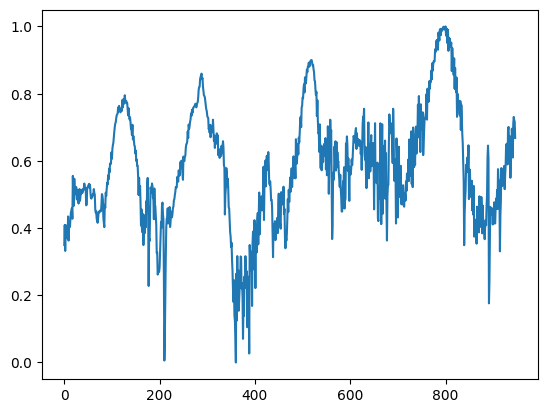

In [32]:
#plot some example training data to check
#parameters are the input, spectra are the output
# print(f'Parameters example: {X_train[0]}, length: {len(X_train[0])}')   

plt.plot(y_train[0])
plt.show()

# Experimenting with autoencoders for finding anomalous spectra 
Using the neural network example notebook as a starting point... 

In [48]:
# FROM NN EXAMPLE CODE
# create an autoencoder

#everything below may be subject to change as we try running this model
# inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
# x = keras.layers.Dense(64, activation="relu")(inp) # 64 neurons with relu activation function
# x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
# x = keras.layers.Dense(8, activation="relu")(x) # 8 neurons with relu activation function (bottleneck layer)
# x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
# x = keras.layers.Dense(64, activation="relu")(x) # 64 neurons with relu activation function
# out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons

#attempt 3: 
# inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
# x = keras.layers.Dense(128, activation="relu")(inp) # 64 neurons with relu activation function
# x = keras.layers.Dense(64, activation="relu")(x)
# x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
# x = keras.layers.Dense(8, activation="relu")(x) # 8 neurons with relu activation function (bottleneck layer)
# x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
# x = keras.layers.Dense(64, activation="relu")(x)
# x = keras.layers.Dense(128, activation="relu")(x) # 64 neurons with relu activation function
# out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons

#attempt 4: 
inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
x = keras.layers.Dense(512, activation="relu")(inp) # 64 neurons with relu activation function
x = keras.layers.Dense(64, activation="relu")(x) # 32 neurons with relu activation function
x = keras.layers.Dense(32, activation="relu")(x) # 8 neurons with relu activation function (bottleneck layer)
x = keras.layers.Dense(64, activation="relu")(x) # 32 neurons with relu activation function
x = keras.layers.Dense(512, activation="relu")(x) # 64 neurons with relu activation function
out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons

autoencoder = keras.models.Model(inp, out) # create model with input and output layers

# compile model
autoencoder.compile(optimizer="adam", loss="mean_squared_error") # use adam optimizer and mean squared error loss function

# print model summary
autoencoder.summary()

# train model with training data and validate with testing data (early stopping is used to avoid overfitting)
history = autoencoder.fit(y_train, y_train, epochs=500, batch_size=32, validation_data=(y_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # this stops training if the validation loss does not decrease for 5 epochs to avoid overfitting

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 947)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       485,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 947)            │       485,811 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041,491 (3.97 MB)

 Trainable params: 1,041,491 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0073 - val_loss: 4.2653e-04
Epoch 2/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 4.3002e-04 - val_loss: 4.6092e-04
Epoch 3/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 3.2616e-04 - val_loss: 2.2761e-04
Epoch 4/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 2.7264e-04 - val_loss: 2.0957e-04
Epoch 5/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 2.4526e-04 - val_loss: 2.3093e-04
Epoch 6/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 2.4495e-04 - val_loss: 1.9382e-04
Epoch 7/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 2.2192e-04 - val_loss: 1.5656e-04
Epoch 8/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 2.1449e-04 - val_loss: 3.0977e-04
Epoch 9/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 2.0526e-04 - val_loss: 2.3360e-04
Epoch 10/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 2.0033e-04 - val_loss: 1.5289e-04
Epoch 11/500
3840/3840 

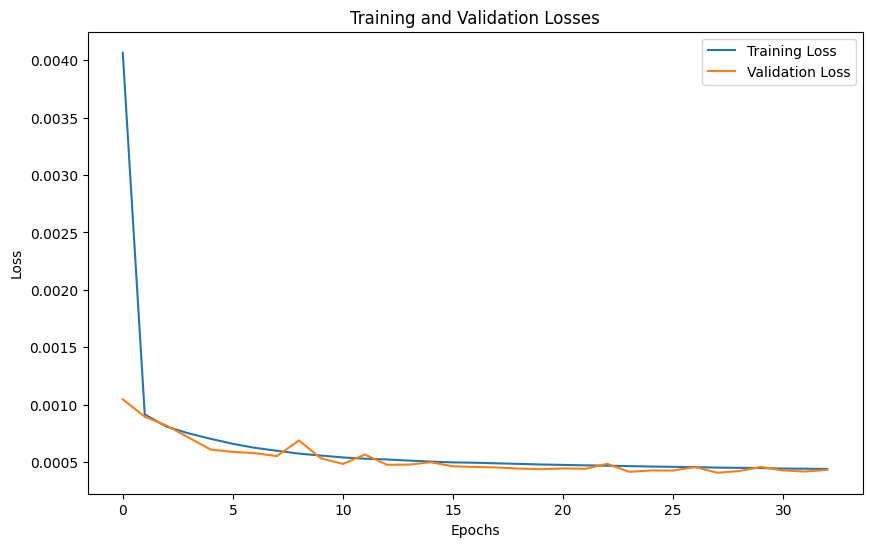

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Training and Validation Losses')
plt.legend()
plt.show()

In [49]:
#try evaluating the model with testing data
loss = autoencoder.evaluate(y_test, y_test)
print(f'Test Loss: {loss}')

960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - loss: 1.6265e-04
Test Loss: 0.00016331294318661094


960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step


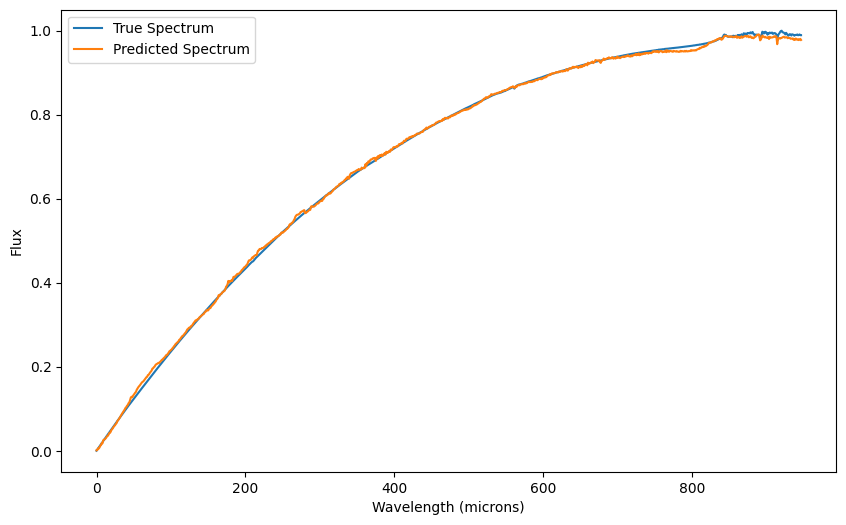

In [50]:
#example predictions
y_pred = autoencoder.predict(y_test)
# y_pred_unscaled = yscaler.inverse_transform(y_pred) 
# y_test_unscaled = yscaler.inverse_transform(y_test)

# wavelengths = np.linspace(0.95, 2.45, len(y_test_unscaled[0]))
wavelengths = np.linspace(0.95, 2.45, len(y_test[0]))

plt.figure(figsize=(10, 6))
# plt.plot(y_test_unscaled[0], label="True Spectrum")
# plt.plot(y_pred_unscaled[0], label="Predicted Spectrum")
plt.plot(y_test[0], label="True Spectrum")
plt.plot(y_pred[0], label="Predicted Spectrum")
plt.legend()
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux")
plt.show()


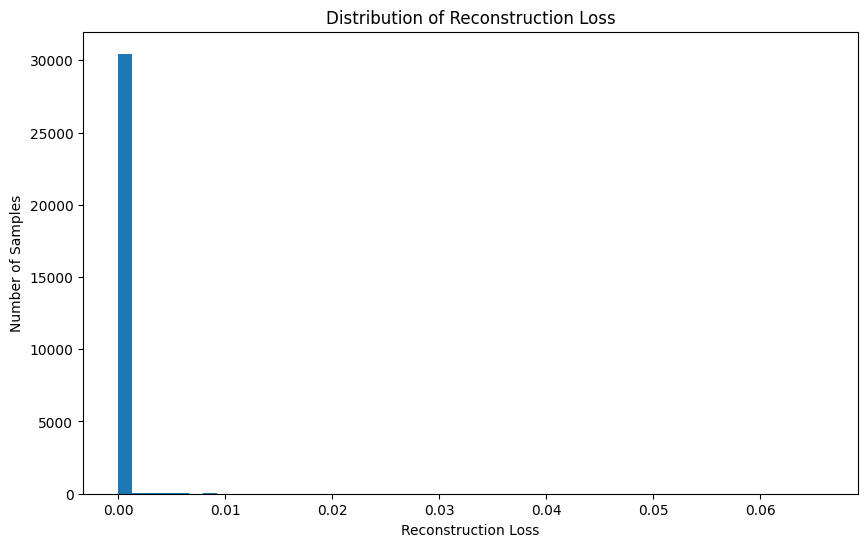

Mean Reconstruction Loss: 0.0001633066798576021
Max Reconstruction Loss: 0.06585938140412251
Min Reconstruction Loss: 2.3799826359315062e-05


In [51]:
#what does the distribution of reconstruction loss look like? 
#in this case, let's find mean squared error (reconstruction loss/error) for each sample

# y_pred_unscaled = yscaler.inverse_transform(y_pred)
# y_test_unscaled = yscaler.inverse_transform(y_test)

# reconstruction_loss = np.mean((y_pred_unscaled - y_test_unscaled)**2, axis=1)

reconstruction_loss = np.mean((y_pred - y_test)**2, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Loss")
plt.show()

print(f'Mean Reconstruction Loss: {np.mean(reconstruction_loss)}')
print(f'Max Reconstruction Loss: {np.max(reconstruction_loss)}')
print(f'Min Reconstruction Loss: {np.min(reconstruction_loss)}')

[11975 15291 12530  7085  9233 22710  1408 26006  6850 21164]


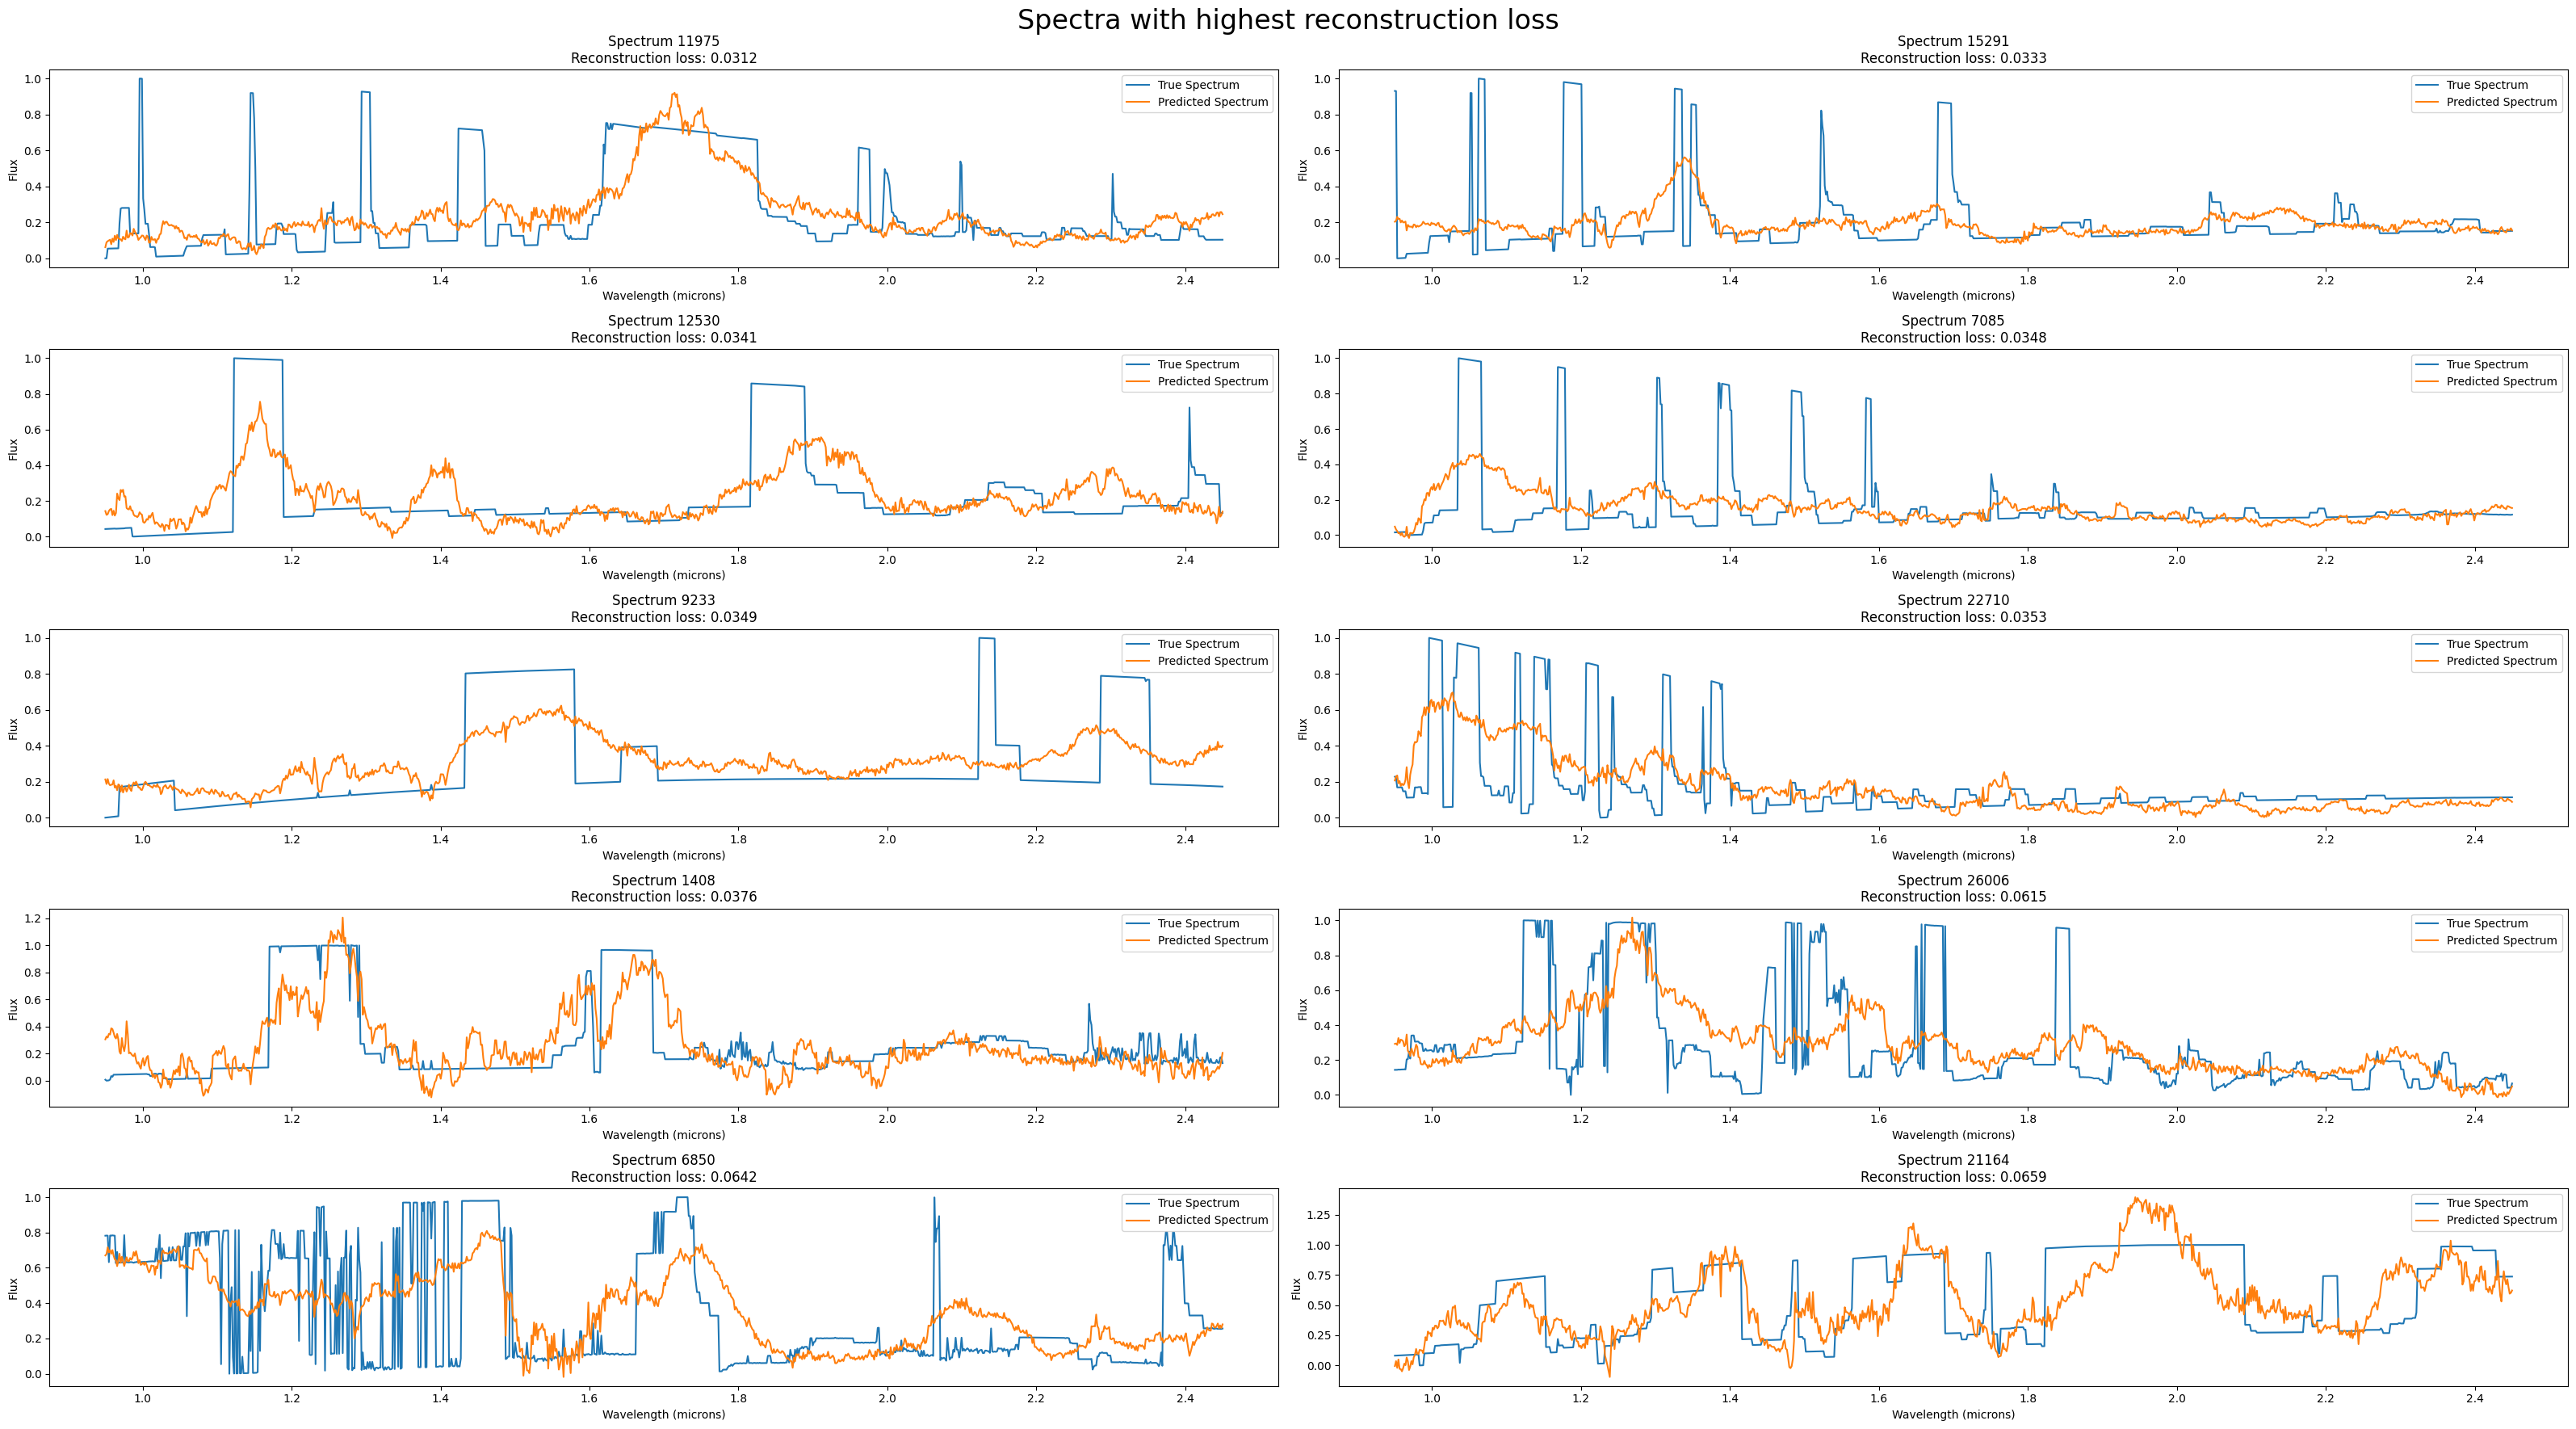

In [56]:
#what do the spectra with the worst (highest) reconstruction loss look like? 
#let's plot the 10 worst spectra... 
worst_indices = np.argsort(reconstruction_loss)[-10:]
print(worst_indices)

fig, axs = plt.subplots(5, 2, figsize=(16*2, 9*2))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    # axs[i].plot(wavelengths, y_test_unscaled[idx], label="True Spectrum")
    # axs[i].plot(wavelengths, y_pred_unscaled[idx], label="Predicted Spectrum")
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()

[13770  2536 24835 18670 26096  2464  5696 11976  5921 25606 22601 27726
 11194 11226 13408 22277 13677 15784 24380 14499 12906  6957 10136  5033
  6432 27474 20378   614 25053  9777 18013 13243 22517 18604  1978 15680
  8519 17325 16482 10007  5450  3984  6512 30258 24871 24122  8896 17690
 13376 22077  6305  4970 13258 27156 17340 25378  9801 30609  4009 23454
  9267  7528  4526 24196 28646  8142 15033 24702  5487 12101  3118 16157
 15661  3681 23821  4452 16148  2234 12995  2182   890 11162 25248  4166
 20655  6322 27941 19657 26518 11584 11975 15291 12530  7085  9233 22710
  1408 26006  6850 21164]


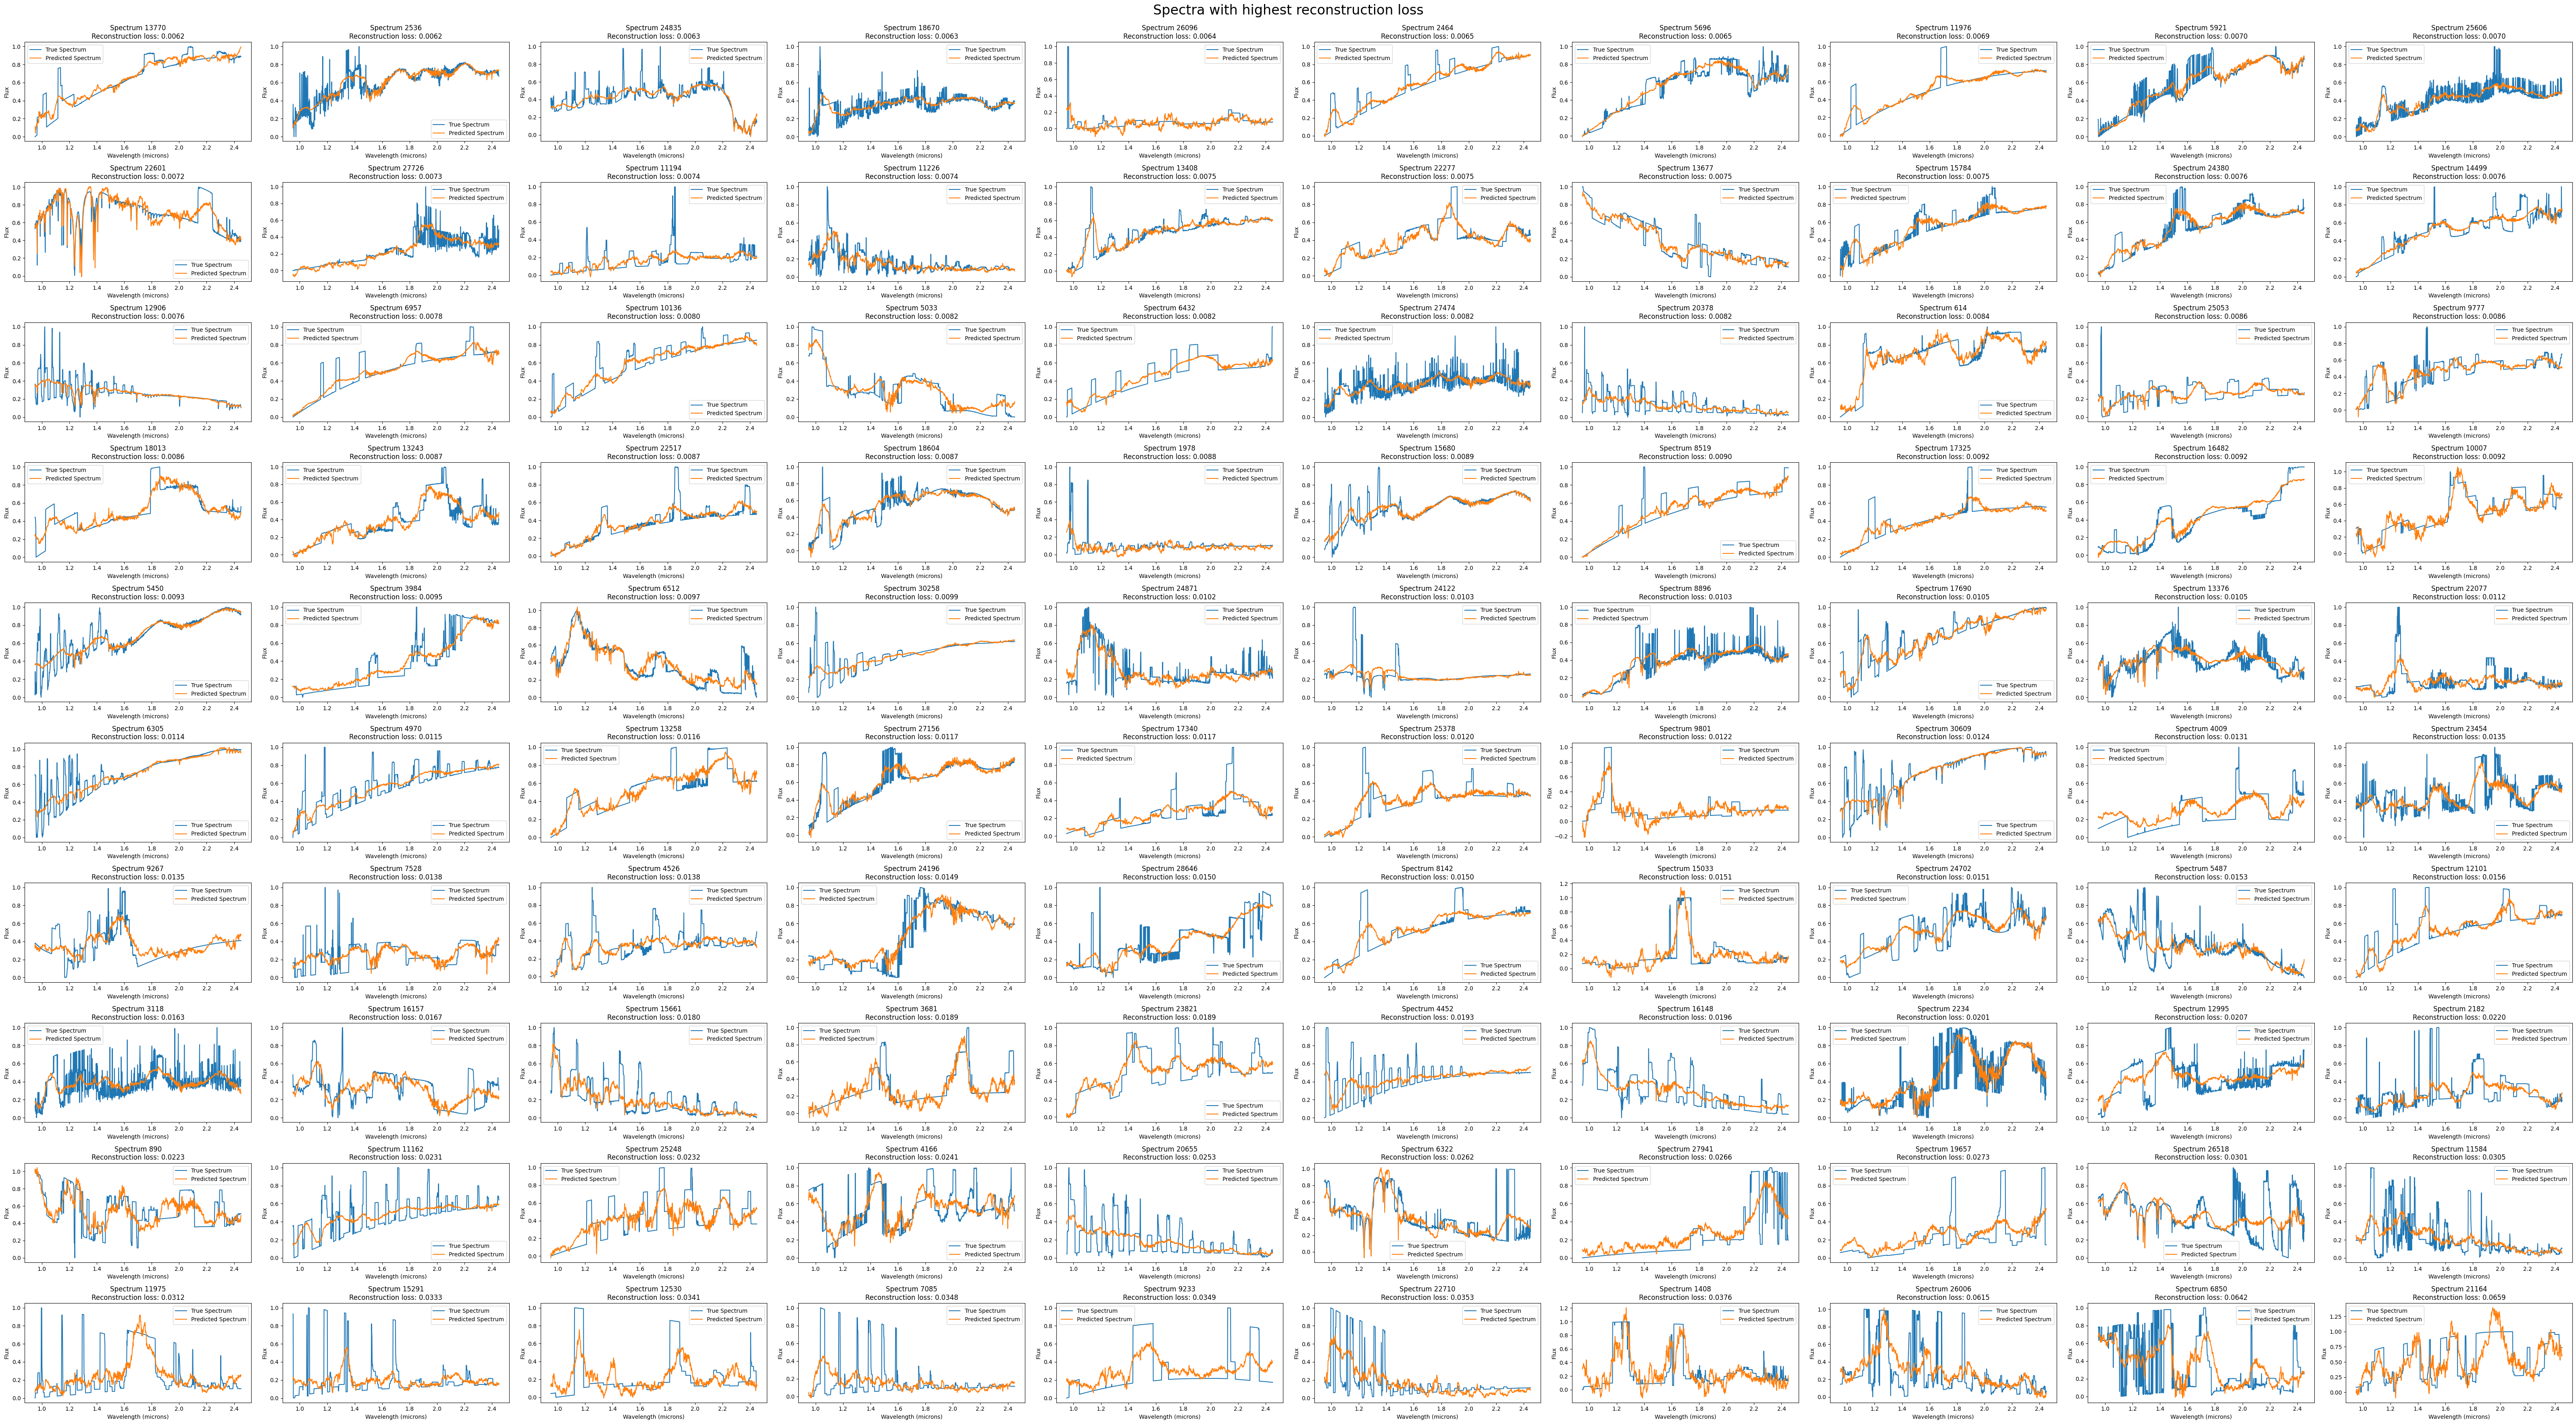

In [55]:
#what about the 100 spectra with the highest reconstruction loss?

worst_indices = np.argsort(reconstruction_loss)[-100:]
print(worst_indices)

fig, axs = plt.subplots(10, 10, figsize=(16*4, 9*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    # axs[i].plot(wavelengths, y_test_unscaled[idx], label="True Spectrum")
    # axs[i].plot(wavelengths, y_pred_unscaled[idx], label="Predicted Spectrum")
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()